In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

from utils.predictor import LinearPredictor, KNNPredictor
from utils.ts_data import Data

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
silver_data = os.path.join("data", "Silver_Futures_Historical_Data.csv")
gold_data = os.path.join("data", "Gold_Futures_Historical_Data.csv")

# Analyze Silver Trend

## Price

Load the data using the custom `Data` class

In [4]:
silver = Data(silver_data)

Plot the time stream data

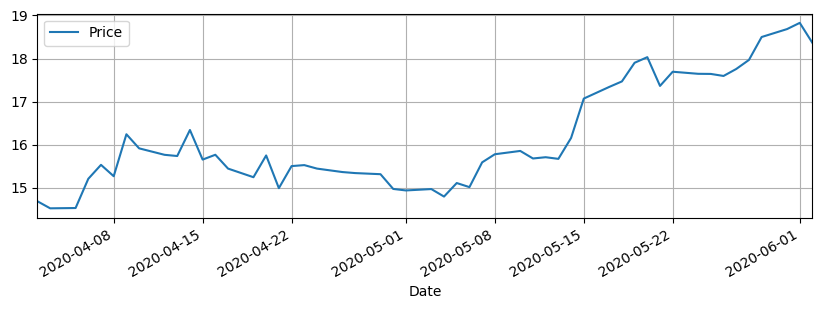

In [5]:
silver.plot_ts(column="Price")

Plot the autocorrleation and partial autocorrelation

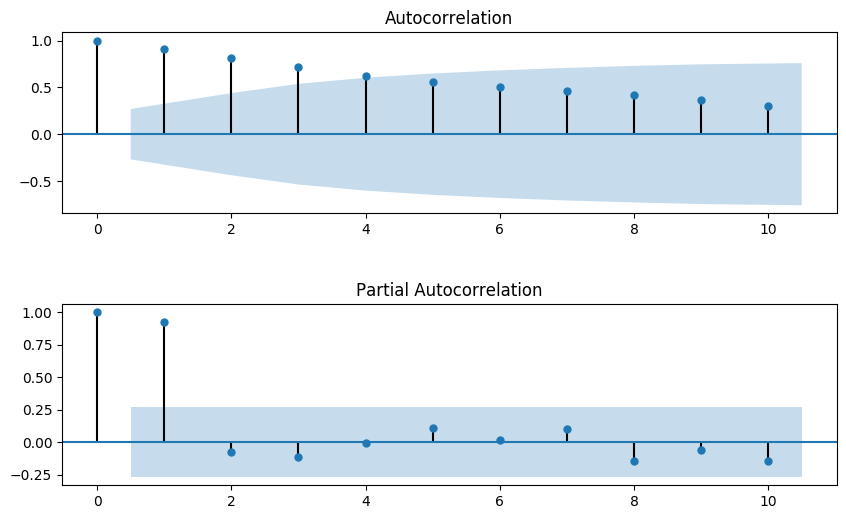

In [6]:
silver.plot_corr(column="Price")

Plot the price histogram

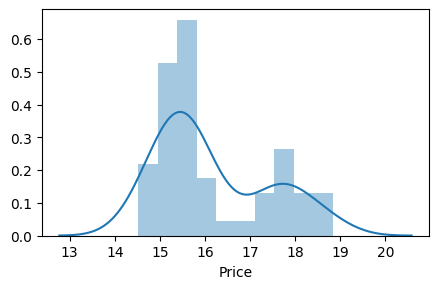

In [7]:
silver.plot_hist(column="Price")

Summarize the data table 

In [8]:
silver.summary

,Price,Open,High,Low,Vol.,Change %
count,53.000000,53.000000,53.000000,53.000000,41.000000,53.000000
mean,16.160453,16.088434,16.391189,15.877981,37.665366,0.536604
std,1.221176,1.195716,1.204729,1.181922,24.493971,2.340232
min,14.523000,14.140000,14.570000,14.030000,4.380000,-4.820000
25%,15.315000,15.325000,15.535000,15.085000,17.540001,-0.630000
50%,15.709000,15.700000,15.940000,15.510000,35.610001,0.150000
75%,17.364000,17.225000,17.684999,17.125000,61.040001,1.890000
max,18.827000,18.855000,18.950001,18.469999,91.019997,6.380000


Run ADF test for stationarity according to [this](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)

In [9]:
silver.adf_test()

Results of ADF Test on Price:


Test Statistic   -0.651571
p-value           0.858898
Lags Used         0.000000
dtype: float64

The p-value is larger than 0.05 so the null hypothesis that the series is not stationary cannot be rejected.

## Return

Let's check out the properties of daily returns

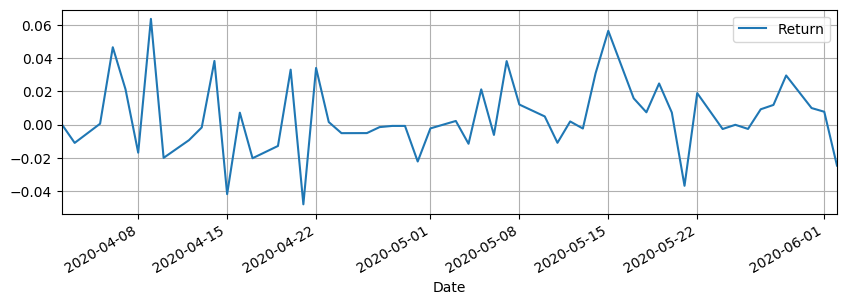

In [10]:
silver.plot_ts(column="Return")

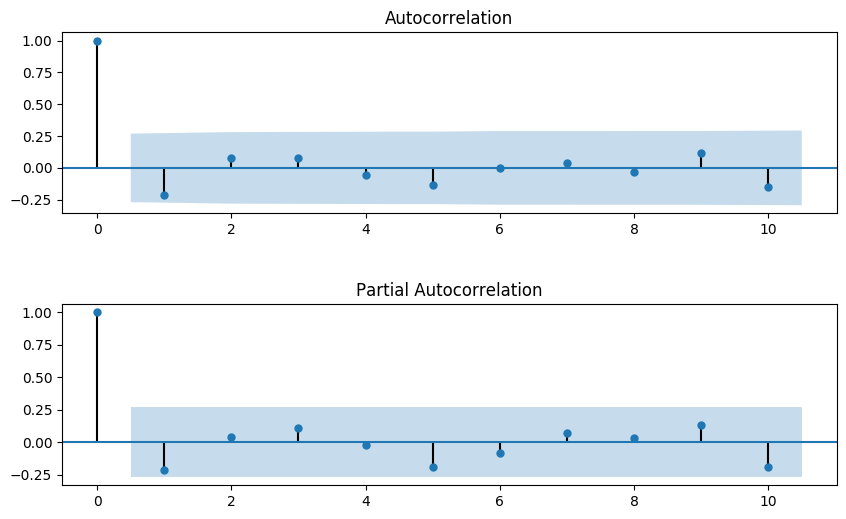

In [11]:
silver.plot_corr("Return")

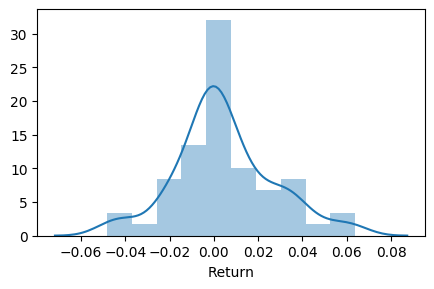

In [12]:
silver.plot_hist("Return")

Some stats on Returns

In [13]:
print(f"Return mean = {silver.df['Return'].mean():.4f}")
print(f"Return std = {silver.df['Return'].std():.4f}")
print(f"Return skewness = {silver.df['Return'].skew():.4f}")
print(f"Return kurtosis = {silver.df['Return'].kurtosis():.4f}")

Return mean = 0.0045
Return std = 0.0227
Return skewness = 0.3142
Return kurtosis = 0.5948


In [14]:
silver.adf_test("Return")

Results of ADF Test on Return:


Test Statistic   -8.682852e+00
p-value           4.239862e-14
Lags Used         0.000000e+00
dtype: float64

The p-value is smaller than 0.05 indicating the series is stationary.

## Specific date range

Providing start and end date to the `Data` class limits the analysis to that range. For example let's look at the results in May:

In [15]:
silver_range = Data(silver_data, start_date="2020-05-01", end_date="2020-05-31")

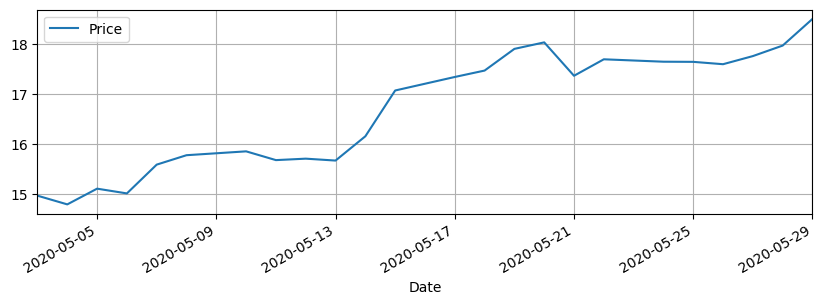

In [16]:
silver_range.plot_ts("Price")

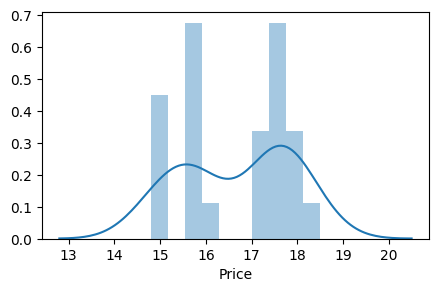

In [17]:
silver_range.plot_hist()

# Prediction

We will use a simple autoregressive model to predict the return of each day, using the return from the previous day. The data model has already calculated the prices (`P`) and returns (`R`) at times `t` and `t-1` for us. Let's check out the dataframe:

In [18]:
silver.df.head()

,Date,Price,Open,High,Low,Vol.,Change %,P_t,P_t-1,Return,R_t,R_t-1,log_Vol
0,2020-04-02,14.686,14.140,14.745,14.030,5.220000,4.72,14.686,14.686,0.000000,0.000000,0.000000,1.652497
1,2020-04-03,14.523,14.655,14.765,14.465,4.380000,-1.11,14.523,14.686,-0.011099,-0.011099,0.000000,1.477049
2,2020-04-05,14.530,14.500,14.570,14.357,NaN,0.05,14.530,14.523,0.000482,0.000482,-0.011099,NaN
3,2020-04-06,15.208,14.590,15.430,14.400,8.270000,4.67,15.208,14.530,0.046662,0.046662,0.000482,2.112635
4,2020-04-07,15.532,15.325,15.950,15.275,18.280001,2.13,15.532,15.208,0.021305,0.021305,0.046662,2.905808


Let's check out the trend for Prices and Returns in consecutive days.

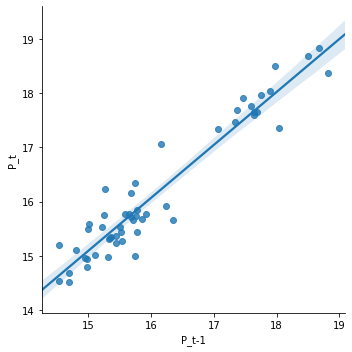

In [21]:
sns.lmplot("P_t-1", "P_t", silver.df)

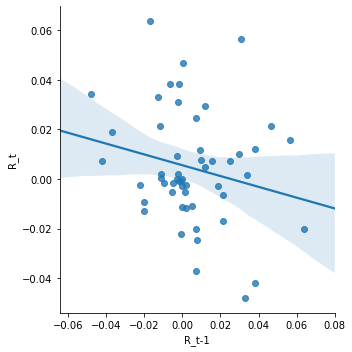

In [22]:
sns.lmplot("R_t-1", "R_t", silver.df)

## Models

### Linear Regression

The `LinearPredictor` model predicts `R_t` (target/response) from `R_t-1` (feature/predictor) using linear regression.

$R_t$ = $\alpha_0 + \alpha_1 \times R_{t-1} + \epsilon_t$

In [23]:
linear_predictor = LinearPredictor(data=silver.df, features=["R_t-1"], train_ratio=0.8)

In [24]:
linear_predictor.build_model()

The data is already split into test and train sets 

Text(0, 0.5, 'y_train')

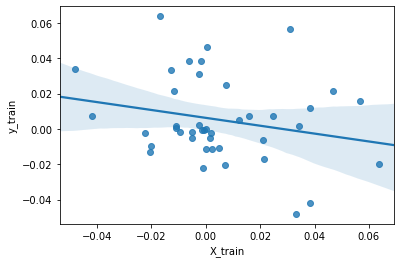

In [25]:
sns.regplot(linear_predictor.X_train.values, linear_predictor.y_train.values[:,0], )
plt.xlabel("X_train")
plt.ylabel("y_train")

Calculate the root mean square error using the test data:

In [26]:
f"{linear_predictor.get_RMSE():.5f}"

'0.01816'

The model has a convenient method that returns the predictions from a specified date onwards. Let's predict the price for 4 days after June 2nd:

In [27]:
four_day_forecast = linear_predictor.forecast_price_on("2020-06-02", n_days=4)

In [28]:
four_day_forecast

,Date,Forecast Price,Forecast Returns
0,2020-06-02,18.360001,-0.024805
1,2020-06-03,18.576869,0.011812
2,2020-06-04,18.644669,0.003650
3,2020-06-05,18.746639,0.005469
4,2020-06-06,18.841564,0.005064


And now overplot this on our original data

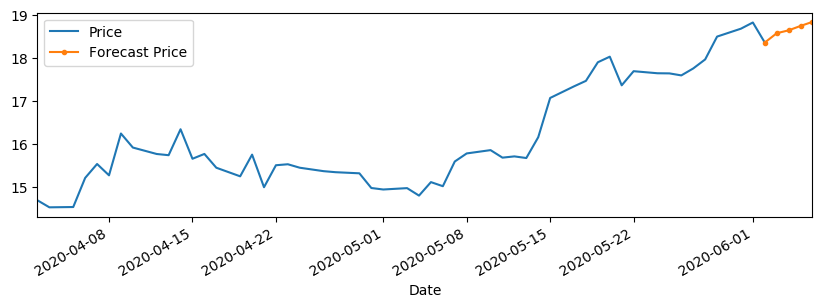

In [29]:
silver.plot_ts(forecasts=[four_day_forecast], marker='.')

It's also possible to pass a list of forecasts to the `plot_ts` method and overlay them on the original data. Let's make 4-day predictions for roughly once a week from the first day:

In [30]:
gap_days = 7 

forecast_dates = silver.df.Date[::gap_days].dt.strftime("%Y-%m-%d").values

In [31]:
forecast_list = [linear_predictor.forecast_price_on(date, n_days=4) for date in forecast_dates]

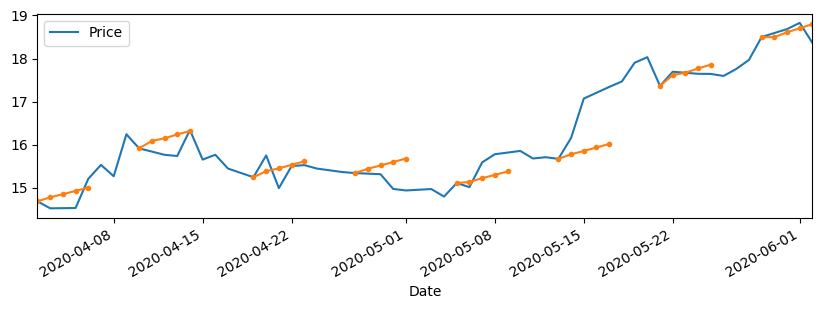

In [32]:
silver.plot_ts(forecasts=forecast_list, legend=False, color="tab:orange", marker='.')


### KNN Regression

`KNNPredictor` uses the same model as before, but it employs a K-nearest-neighbors regressor instead of a linear regressor. 

In [33]:
knn_predictor = KNNPredictor(data=silver.df, features=["R_t-1"], train_ratio=0.8)

Let's find the best K by looking at the RMSE plot

In [34]:
RMSE_list = []
n_neighbors= np.arange(1,8)

for n in n_neighbors:
    knn_predictor.build_model(n_neighbors=n)
    RMSE_list.append(knn_predictor.get_RMSE())

Text(0.5, 0, 'K')

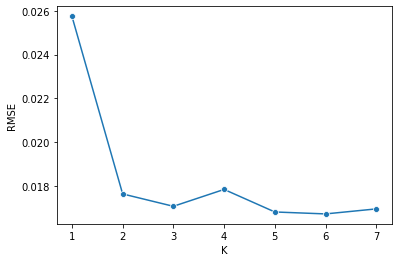

In [35]:
sns.lineplot(n_neighbors, RMSE_list, marker="o")
plt.ylabel("RMSE")
plt.xlabel("K")

3 seems to be a good choice.

In [36]:
knn_predictor.build_model(n_neighbors=3)

In [37]:
knn_predictor.get_RMSE()

0.017063904114942463

the RMSE is slightly better than the linear predictor. As a reminder

In [38]:
linear_predictor.get_RMSE()

0.01815698553744429

Here we repeat the same forecast steps as before, but with KNN this time. 

In [39]:
four_day_forecast = knn_predictor.forecast_price_on("2020-06-02", n_days=4)

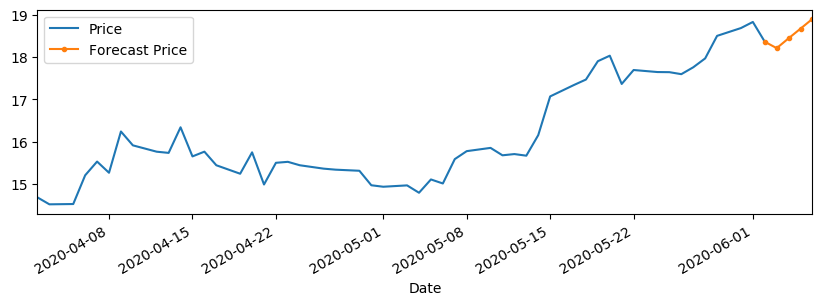

In [40]:
silver.plot_ts(forecasts=[four_day_forecast], marker='.')

In [41]:
gap_days = 7
forecast_dates = silver.df.Date[::gap_days].dt.strftime("%Y-%m-%d").values
forecast_list = [knn_predictor.forecast_price_on(date, n_days=4) for date in forecast_dates]

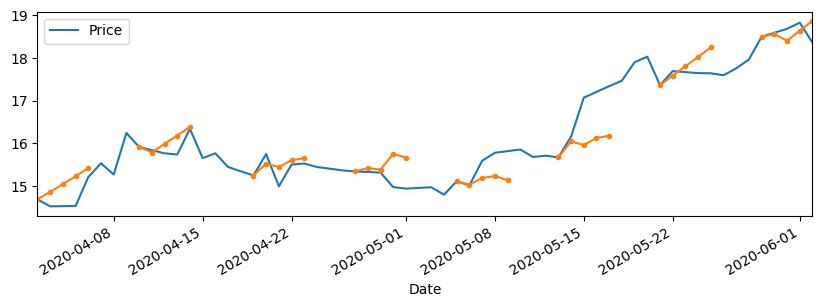

In [42]:
silver.plot_ts(forecasts=forecast_list, legend=False, color="tab:orange", marker='.')


In [50]:
import statsmodels
statsmodels.__version__

'0.10.1'